# Pytorch를 사용한 선형 SVM 모델 학습 및 결정 경계 시각화 실습

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

### 데이터 생성

In [2]:
x = torch.randn(100, 2)
y = torch.where(x[:,0] > x[:,1] , 1, -1).float()

dataset = TensorDataset(x, y)
loader = DataLoader(dataset, batch_size=36)

### SVM 모델 정의 

In [3]:
class SVM(nn.Module) : 
    def __init__(self) : 
        super().__init__()
        self.linear = nn.Linear(2,1)
        
    def forward(self, x) : 
        return self.linear(x)

### 모델 , 손실 함수, 옵티마이저 생성

In [4]:
model = SVM()
criterion = nn.HingeEmbeddingLoss() # 양성 1 음성 -1 클래스로 지정되어 있어야 사용가능 
# (주어진 입력과 대상 사이의 경계선 손실값 계산 하는 함수) -> 이진 분류 문제에서 사용 
optimizer = optim.SGD(model.parameters(), lr=0.001)

### 모델 학습 loop

In [5]:
for epoch in range(1000) : 
    for inputs, targets in loader : 
        output = model(inputs)
        loss = criterion(output.squeeze() , targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 10 == 0 : 
        print(f"Epoch [{epoch + 1} / 50] , Loss : {loss.item():4f}")

Epoch [10 / 50] , Loss : -0.019803
Epoch [20 / 50] , Loss : -0.041418
Epoch [30 / 50] , Loss : -0.063034
Epoch [40 / 50] , Loss : -0.084650
Epoch [50 / 50] , Loss : -0.106265
Epoch [60 / 50] , Loss : -0.127881
Epoch [70 / 50] , Loss : -0.149038
Epoch [80 / 50] , Loss : -0.170144
Epoch [90 / 50] , Loss : -0.190971
Epoch [100 / 50] , Loss : -0.211613
Epoch [110 / 50] , Loss : -0.232254
Epoch [120 / 50] , Loss : -0.252896
Epoch [130 / 50] , Loss : -0.273538
Epoch [140 / 50] , Loss : -0.294179
Epoch [150 / 50] , Loss : -0.314821
Epoch [160 / 50] , Loss : -0.335462
Epoch [170 / 50] , Loss : -0.355897
Epoch [180 / 50] , Loss : -0.374100
Epoch [190 / 50] , Loss : -0.391751
Epoch [200 / 50] , Loss : -0.409403
Epoch [210 / 50] , Loss : -0.427055
Epoch [220 / 50] , Loss : -0.444706
Epoch [230 / 50] , Loss : -0.461591
Epoch [240 / 50] , Loss : -0.477765
Epoch [250 / 50] , Loss : -0.493940
Epoch [260 / 50] , Loss : -0.510114
Epoch [270 / 50] , Loss : -0.526289
Epoch [280 / 50] , Loss : -0.542464
E

### 시각화 

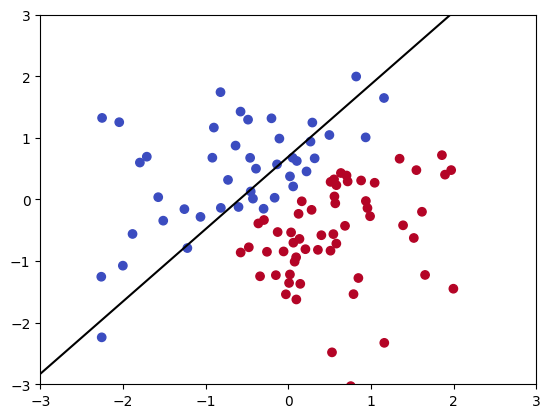

In [6]:
# 결정 경계 시각화
import matplotlib.pyplot as plt
import numpy as np

w = list(model.parameters())[0][0]
b = list(model.parameters())[1].item()
slope = (-w[0] / w[1]).detach().numpy()
intercept = (-b / w[1]).detach().numpy()
x_range = np.linspace(-3, 3, 100)
y_range = slope * x_range + intercept

plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.plot(x_range, y_range, 'k-')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

# 간단한 이상 탐지 예제를 파이토치로 구현 이 예제에서는 One-class-SVM을 사용하여 데이터 이상을 탐지 

In [7]:
import torch
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.svm import OneClassSVM


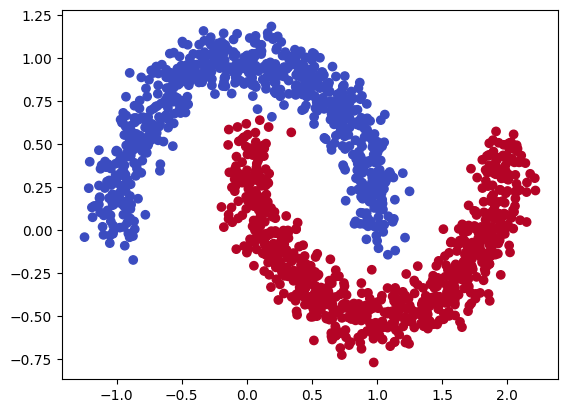

In [8]:
x, y = make_moons(n_samples=1500, noise=0.1, random_state=777)

# 데이터 시각화 
plt.scatter(x[:,0], x[:,1], c=y, cmap=plt.cm.coolwarm)
plt.show()

### 이상 데이터 설정

In [9]:
outliers_ratio = 0.1                      #### 이상치 비율 
n_outliers = int(outliers_ratio * len(x))  ### 이상치 데이터 개수     
n_inliers = len(x) - n_outliers            ### 정상 데이터 개수 
  
rng = np.random.RandomState(777)           ### 난수 생성 객체 
x_outliers = 1.5 * rng.uniform(low=-1, high=3, size=(n_outliers, 2)) ### 이상치 데이터 생성 난수 생성을 이용해서 uniform 분포를 
# 따르는 값을 생성 -> 1.5배 해서 이상치 데이터를 생성
x = np.vstack([x, x_outliers])  # 이상치 데이터를 기존 데이터 추가 
y = np.hstack([y, -1 * np.ones(n_outliers)]) # 이상치 데이터의 클래스는 -1로 설정합니다. 

In [10]:
# 데이터 정규화 
x = (x - x.mean(axis=0)) / x.std(axis=0)

# 학습 데이터 평가 데이터 분리 
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.1, random_state=777)

# One-class SVM 모델 학습 
model = OneClassSVM(nu=0.05, kernel='rbf', gamma='auto')
model.fit(x_train)

# 이상치 탐지 
y_pred = model.predict(x_test)
y_pred = np.where(y_pred == 1, 0, y_pred) # 1을 0으로 -1을 1로 변환 
score = f1_score(y_test, y_pred, average='macro')

"""
F1 score 는 정밀도 와 재현율의 조화 평균으로 계산 됩니다. 

정밀도 = TP / (TP + FP)
재현율 = TP / (TP + FN)

F1 score = 2 * (정밀도 * 재현율) / (정밀도 + 재현율)

FN : 거짓 음성 -> 실제는 양성인데 음성이라고 하는 경우 
TP : 참 양성 -> 실제 양성인데 양성이라고 하는 경우 
FP : 거짓 양성 - > 실제는 음성인데 양성이라고 하는 경우 

F1 스코어 : 0부터 1까지 값을 가지고 1에 가까우면 좋은 모델 
"""

print(f"F1 score >> " , score)

F1 score >>  0.385644087827331


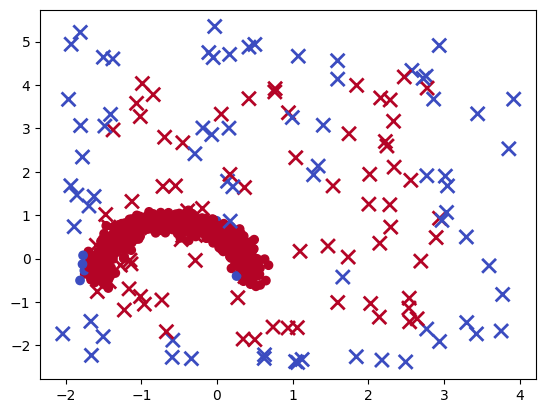

In [11]:
# 모든 데이터 포인트에 대한 예측 결과 얻기
y_pred_all = model.predict(x)

# 이상치 데이터와 정상 데이터를 분리하여 시각화
X_inliers = x[y == 0]
X_outliers = x[y == -1]
y_pred_inliers = y_pred_all[y == 0]
y_pred_outliers = y_pred_all[y == -1]

plt.scatter(X_inliers[:, 0], X_inliers[:, 1], c=y_pred_inliers, cmap=plt.cm.coolwarm)
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c=y_pred_outliers, cmap=plt.cm.coolwarm, marker='x', 
            s=100, linewidth=2)
plt.show()

# SVM을 활용한 이미지 분류

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.svm import SVC
from tqdm import tqdm

### 데이터 로드 

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.3,))
])

train_dataset = torchvision.datasets.MNIST(root="./dataset", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root="./dataset" , train=False, download=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=2)

### 특징 추출

In [14]:
train_features = []
train_labels = []

for i, data in enumerate(train_loader, 0) : 
    inputs, labels = data 
    inputs = inputs.view(inputs.shape[0], -1)
    train_features.append(inputs)
    train_labels.append(labels)
"""
train_loader 미니배치 데이터 -> 2차원으로 펼친 후 -> train_feature, train_labels 각 리스트에 저장 -> 최종 텐서 변환 (훈련 데이터 사용가능)
"""    
train_features = torch.cat(train_features, dim=0)
train_labels = torch.cat(train_labels, dim=0)

test_features = []
test_labels = []
for i, data in enumerate(test_loader, 0) : 
    inputs, labels = data
    inputs = inputs.view(inputs.shape[0], -1)
    test_features.append(inputs)
    test_labels.append(labels)
    
test_features = torch.cat(test_features, dim=0)
test_labels = torch.cat(test_labels, dim=0)

### SVM을 활용한 이미지 분류 

In [ ]:
import time 
print("SVM MODEL TRAIN AND TEST")
start_time = time.time()
model = SVC(C=1.0, kernel='rbf', gamma=0.01)
model.fit(train_features.numpy(), train_labels.numpy())
acc = model.score(test_features.numpy(), test_labels.numpy())

end_tiem = time.time()
print("ACC >>" , acc)
train_tiem = end_tiem - start_time
print("Training Time : {:.2f} seconds".format(train_tiem))


In [ ]:
# 예측 결과 시각화
def plot_images(images, labels, preds):
    fig, axes = plt.subplots(1, 10, figsize=(10, 1))
    
    for i, ax in enumerate(axes):
        ax.imshow(images[i].reshape((28, 28)), cmap='gray')
        title = 'label: {}\npred: {}'.format(labels[i], preds[i])
        ax.set_title(title)
        ax.axis('off')
    plt.subplots_adjust(top=0.5, bottom=0, hspace=0, wspace=0.5)
    plt.show()

# 테스트 이미지 가져오기
test_images, test_labels = next(iter(testloader))
test_images = test_images.view(test_images.shape[0], -1)

# 모델 예측
test_preds = model.predict(test_images.numpy())

# 결과 시각화
plot_images(test_images.numpy(), test_labels.numpy(), test_preds)

# GridSearchCV SVM 모델 최적 하이퍼파리미터 찾기 

In [1]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
# 데이터 생성
rng = np.random.RandomState(0)
x = rng.randn(100, 10)
y = rng.binomial(1, 0.5 , 100)

In [3]:
# 파이프라인 생성
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

In [4]:
# 탐색할 하이퍼파라미터 그리그 생성 
param_grid = {
    'svm__C' : [0.1, 1, 10],
    'svm__kernel' : ['linear', 'rbf'],
    'svm__gamma' : ['scale', 'auto']
}

### 그리드 서치 수행 

In [5]:
grid_search = GridSearchCV(svm_pipeline, param_grid, cv=5)
grid_search.fit(x,y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC())]),
             param_grid={'svm__C': [0.1, 1, 10],
                         'svm__gamma': ['scale', 'auto'],
                         'svm__kernel': ['linear', 'rbf']})

### 최적 하이퍼 파라미터와 최고 성능 출력 

In [6]:
print("Best parameters : ", grid_search.best_params_)
print("Best cross-validation score : ", grid_search.best_score_)

Best parameters :  {'svm__C': 0.1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best cross-validation score :  0.5799999999999998


# SVM 하이퍼파라미터 최적화 - 랜덤 서치 

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import loguniform

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

In [8]:
# 데이터 로드 
digits = load_digits()

# 독립 변수 , 종속 변수 데이터 지정
x = digits.data
y = digits.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### 탐색할 하이퍼파라미터 공간

In [9]:
params = {
    "C" : loguniform(1e-4, 100),
    'kernel' : ["linear", 'poly', 'rbf', 'sigmoid'],
    'gamma' : ['scale', 'auto'] + list(loguniform(1e-4, 10).rvs(10)),
    'degree' : range(1,6),
    'coef0' : loguniform(1e-4, 10).rvs(10)
}

In [10]:
svm_model = SVC()

random_search = RandomizedSearchCV(svm_model, params , n_iter=100, cv=5, verbose=2, n_jobs=-1)

random_search.fit(x_train, y_train)

print(random_search.best_params_)

# 최적 모델 저장 
best_model = random_search.best_estimator_

# 테스트 데이터 에 대한 예측 수행 
y_pred = best_model.predict(x_test)

print("ACC > " , accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.
